In [1]:
import os
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

np.random.seed(462)

In [2]:
def load_data(filename):
    # Adjust the path if your folder structure is different
    path = os.path.join("..", "data", "tabular", filename)
    data = pl.read_csv(path).to_numpy()
    X = data[:, :-1].astype(float)
    y = data[:, -1]
    
    # Encode labels (e.g., 'banana' -> 0) to compute ARI later
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    
    return X, y_encoded, encoder

In [3]:
# Load the dataset
X_train, y_train, encoder = load_data("train_processed.csv")
# Scale the data (Crucial for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

Searching for optimal k between 2 and 15...
------------------------------------------------------------
k   | Silhouette   | ARI (Truth)  | Inertia   
------------------------------------------------------------
2   | 0.2116       | 0.0479       | 285539
3   | 0.1572       | 0.0496       | 264960
4   | 0.1355       | 0.0600       | 265585
5   | 0.0914       | 0.1572       | 253117
6   | 0.0815       | 0.1464       | 244026
7   | 0.0792       | 0.1241       | 239506
8   | 0.0610       | 0.1324       | 233968
9   | 0.0633       | 0.1368       | 231797
10  | 0.0632       | 0.1500       | 229051
11  | 0.0609       | 0.1411       | 227082
12  | 0.0585       | 0.1419       | 224749
13  | 0.0478       | 0.1237       | 221712
14  | 0.0453       | 0.1188       | 219947
------------------------------------------------------------
Best k found: 2 (Silhouette: 0.2116)

--- Checking performance for k=5 (True Class Count) ---
Silhouette: 0.0914
ARI Score:  0.1572 (1.0 means perfect match with label

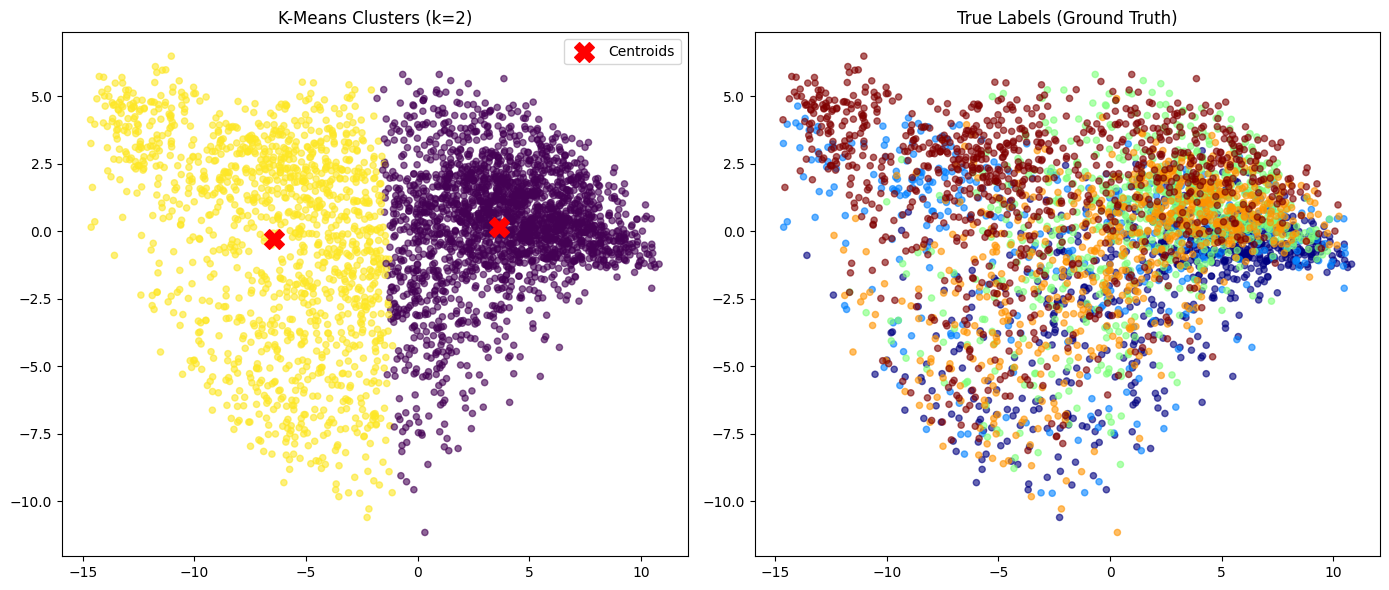


Confusion Matrix (Cluster vs True Class):
Cluster       0    1
True Label          
banana      520  155
carrot      232  191
cucumber    589  161
mandarin    486  208
tomato      347  601


In [ ]:
class Clustering:
    def __init__(self, X, y, seed=42):
        self.X_raw = X
        self.y = y
        self.seed = seed

        # Scale the dataset, if not done in the dataset
        self.scaler = StandardScaler()
        self.X_std = self.scaler.fit_transform(X)

        # Placeholder
        self.best_model  = None
        self.best_labels = None
        self.best_k      = None

    def find_optimal_k(self, k_min=2, k_max=20):
        """
        Run K-Means over a range of k values and keep track of best stats.
        """
        print(f"Searching for optimal k between {k_min} and {k_max}...")
        print("-" * 60)
        print(f"{'k':<3} | {'Silhouette':<12} | {'ARI (Truth)':<12} | {'Inertia':<10}")
        print("-" * 60)

        best_score = -1

        for k in range(k_min, k_max):
            # MiniBatchKMeans should be good in this case, since we have over 3000 data points
            km = MiniBatchKMeans(5
                n_clusters=k,
                batch_size=256,
                random_state=self.seed,
                n_init='auto'
            )

            # Predicted clusters for every data point for given k
            labels = km.fit_predict(self.X_std)

            # Cluster Compactness as Internal metric
            sil = silhouette_score(self.X_std, labels)

            # External metric: how well clusters match ground truth
            ari = adjusted_rand_score(self.y, labels)

            print(f"{k:<3} | {sil:.4f}       | {ari:.4f}       | {km.inertia_:.0f}")

            # Track the best k based on silhouette score
            if sil > best_score:
                best_score = sil
                self.best_k = k
                self.best_model  = km
                self.best_labels = labels

        print("-" * 60)
        print(f"Best k found: {self.best_k} (Silhouette: {best_score:.4f})")

    def evaluate_specific_k(self, k):
        """
        Run K-Means for specific k, like true class count, and print out the metrics.
        """
        print(f"\n--- Checking performance for k={k} (True Class Count) ---")

        km = MiniBatchKMeans(
            n_clusters=k,
            batch_size=256,
            random_state=self.seed,
            n_init='auto'
        )

        labels = km.fit_predict(self.X_std)

        sil = silhouette_score(self.X_std, labels)
        ari = adjusted_rand_score(self.y, labels)

        print(f"Silhouette: {sil:.4f}")
        print(f"ARI Score:  {ari:.4f} (1.0 means perfect match with labels)")

        return km, labels

    def visualize_clusters(self):
        """
        Plot the best clustering result vs the ground truth.
        Uses PCA to reduce everything down to 2 dimensions.
        """
        if self.best_model is None:
            print("Run find_optimal_k() first!")
            return

        # Reduce dimensionality just for visualization
        pca = PCA(n_components=2, random_state=self.seed)
        X_pca = pca.fit_transform(self.X_std)

        # Project centroids into PCA space
        centroids_pca = pca.transform(self.best_model.cluster_centers_)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Plot 1: K-Means result
        ax1.scatter(
            X_pca[:, 0],
            X_pca[:, 1],
            c=self.best_labels,
            cmap='viridis',
            s=20,
            alpha=0.6
        )

        ax1.scatter(
            centroids_pca[:, 0],
            centroids_pca[:, 1],
            c='red',
            marker='X',
            s=200,
            label='Centroids'
        )

        ax1.set_title(f'K-Means Clusters (k={self.best_k})')
        ax1.legend()

        # Plot 2: Ground truth labels
        # Using 'jet' so the classes really stand out
        ax2.scatter(
            X_pca[:, 0],
            X_pca[:, 1],
            c=self.y,
            cmap='jet',
            s=20,
            alpha=0.6
        )

        ax2.set_title('True Labels (Ground Truth)')

        plt.tight_layout()
        plt.show()

    def print_confusion_matrix(self, classes):
        if self.best_labels is None:
            return

        print("\nConfusion Matrix (Cluster vs True Class):")

        # Map numeric labels back to class names for readability
        df = pd.DataFrame({
            'Cluster': self.best_labels,
            'True Label': [classes[i] for i in self.y]
        })

        print(pd.crosstab(df['True Label'], df['Cluster']))


# ==========================================
# Usage Example
# ==========================================

# Initialize
clusterer = Clustering(X_train, y_train)

# Iterate over k values
clusterer.find_optimal_k(k_min=2, k_max=15)

# Evalueate for the 5 classes
clusterer.evaluate_specific_k(k=5)

# Visualize results
clusterer.visualize_clusters()

# Print confusion matrix if encoder exists
if 'encoder' in locals():
    clusterer.print_confusion_matrix(encoder.classes_)
